# **Data Science AE3 "HELLO!!!": Exploring the Effects of Behavioral and Demographic Attributes on Health Outcomes**
## **Assesment Task**
The aim of this assignment is to give you hands-on experience in presenting a
comprehensive data science project of your own choice. You will have the
opportunity to select and work with a dataset, applying the knowledge and tools
covered in this term. The project should cover the entire data science workflow,
including data discovery, importing, analysis, visualisation, and presentation. 

<div>
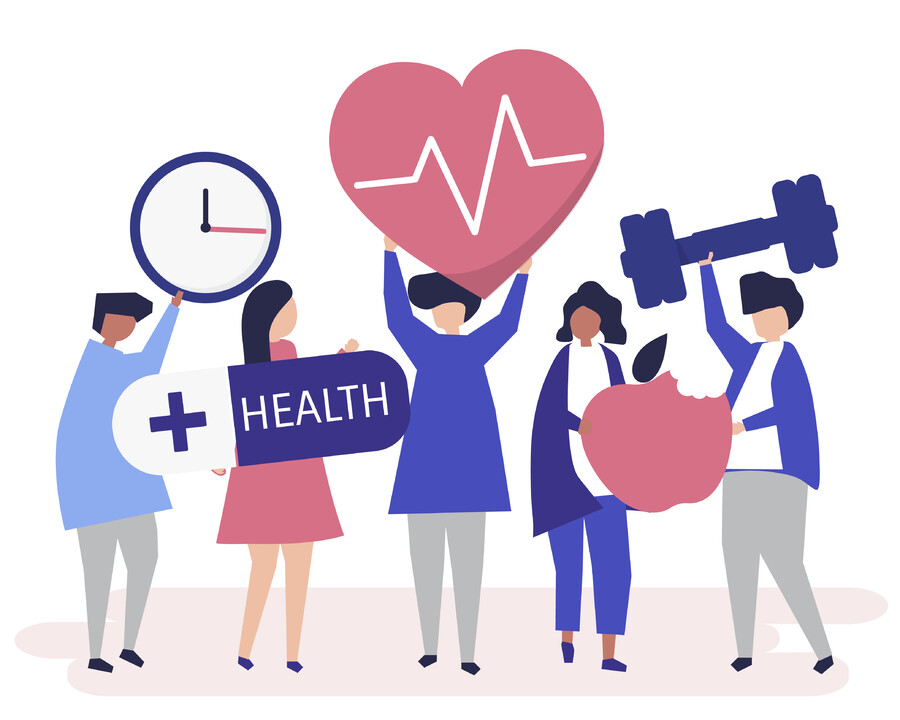
</div>

## **The BRFSS Dataset**
The BRFSS dataset is a state-based health behavior survey that collects information on individuals health risk behaviors such as lifestyle and demographic factors including amount of sleep, smoking and exercise habits, and general health perception as well as chronic illnesses. This data was collected in 2020 and accessed through Kaggle, but was originally downloaded from the CDC website. 

## **Project Aim**
The aim of this project is to cluster and analyze individuals based on their demographic attributes such as age, gender etc. and behavioral attributes such as exercise, sleep and more to examine the correlation between health outcomes. The project does not aim to determine whether or not an individual will get a certain disease based on their attributes, but to analyze the correlation between lifestyle and health outcomes. This is achieved by using K-Nearest Neighbors and Logistic Regression to classify the user's health outcomes, and visualizing the data through Kmeans and histograms. My hypothesis is that there will be a correlation between behavioral and demographic attributes (specifically smoking) and prevelance of chronic diseases. 


## **1. Loading, Processing and Cleaning the Data**

To clean the data, I first filtered the dataset by selecting columns to go in 5 categories: demographics, behavioral, health statistics, immunizations, and disabilities to be useful for analysis. I then aggregate the data by combining columns to produce a single output. For example, combining the 3 immunizations patients reported either receiving or not receiving, and creating a new column to represent the percent of immunizations received. Another example of a column created was the total number of chronic conditions an individual has, by counting the number of conditions a patient had out of 10 conditions. To clean the data, in the columns that had 2 responses, either 1 or 2, I switched each 2 to 0 to make the data more cohesive with convention, as well as dropping null values. 

**Here is the link to the dataset**
https://www.kaggle.com/datasets/aemreusta/brfss-2020-survey-data?resource=download


In [ ]:
# imports 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# hello


In [2]:
def filter_df():
    """
    Parameters
    ----------
    none

    Returns
    -------
    demographics : a list of strings that are the column names of demographic attributes 
    behavioral: a list of strings that are the column names of behavioral attributes 
    health_stats: a list of strings that are the column names of health statistics
    immunizations: a list of strings that are the column names of immunizations
    disabilities : a list of strings that are the column names of disabilities
    filtered_df : a dataframe that includes only the desired columns 
    
    """
    # reads the dataframe using pandas
    health_df = pd.read_csv("/Users/ariaagarwal/Desktop/brfss2020.csv")

    # creates lists of the desired column names for each category
    demographics = ["_STATE", "SEXVAR", "EDUCA", "INCOME2", "_IMPRACE", "_AGE80", "HLTHPLN1", "GENHLTH"]
    behavioral = ["EXERANY2", "SLEPTIM1", "_SMOKER3", "USENOW3", "ALCDAY5"]
    health_stats = ["CVDINFR4", "CVDCRHD4", "CVDSTRK3", "ASTHMA3", "CHCCOPD2", "DIABETE4", "CHCOCNCR", "ADDEPEV3",  "HAVARTH4", "_MICHD"]
    immunizations = ["FLUSHOT7", "SHINGLE2", "PNEUVAC4"]
    disabilities = ["DEAF", "BLIND", "DECIDE", "DIFFWALK", "DIFFDRES", "DIFFALON"]

    # filters the orginal data frame based on each category 
    filtered_df = health_df[demographics + behavioral + health_stats + immunizations + disabilities]

    return demographics, behavioral, health_stats, immunizations, disabilities, filtered_df
    
# calls the function
demographics, behavioral, health_stats, immunizations, disabilities, filtered_df = filter_df()



In [3]:
def process_data(filtered_df, immunizations, health_stats, disabilities):
    """
    Parameters
    ----------
    immunizations: a list of strings that are the column names of immunizations
    health_stats: a list of strings that are the column names of health statistics
    disabilities : a list of strings that are the column names of disabilities

    Returns
    -------
    filtered_df : dataframe with added columns that combined previous columns to create new data 
    
    """
    # initialzes 3 empty lists 
    shots = []
    diseases = []
    disability_list = []
    # iterates through the values in each category of columns 
    for value, disease, disability in zip(filtered_df[immunizations].values, filtered_df[health_stats].values, filtered_df[disabilities].values):
        # counted the number of 1s ("yes") in the respective columns and combined the results accordingly
        # immunizations are divided by 3 to get the percent of immunizations an indivudal has gotten 
        shots.append(len([i for i in value if i == 1.0])/3)
        diseases.append(len([i for i in disease if i == 1.0]))
        disability_list.append(len([i for i in disability if i == 1.0]))
        
    # adds 3 new columns to dataframe 
    filtered_df["immunizations"] = shots
    filtered_df["# chronic diseases"] = diseases
    filtered_df["# disabilities"] = disability_list
    
# calls the function    
process_data(filtered_df, immunizations, health_stats, disabilities)
# drops the 2 old categories of columns that are no longer needed
filtered_df = filtered_df.drop(immunizations + disabilities, axis = 1)
filtered_df


,_STATE,SEXVAR,EDUCA,INCOME2,_IMPRACE,_AGE80,HLTHPLN1,GENHLTH,EXERANY2,SLEPTIM1,...,ASTHMA3,CHCCOPD2,DIABETE4,CHCOCNCR,ADDEPEV3,HAVARTH4,_MICHD,immunizations,# chronic diseases,# disabilities
0,1.0,2.0,6.0,1.0,1.0,56.0,2.0,2.0,1.0,5.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.000000,6,1
1,1.0,2.0,6.0,99.0,2.0,65.0,1.0,3.0,1.0,7.0,...,1.0,2.0,3.0,2.0,1.0,1.0,2.0,0.000000,3,0
2,1.0,2.0,5.0,7.0,2.0,65.0,1.0,3.0,1.0,7.0,...,2.0,2.0,3.0,1.0,2.0,1.0,2.0,0.333333,2,0
3,1.0,2.0,4.0,99.0,1.0,80.0,1.0,1.0,2.0,6.0,...,2.0,2.0,3.0,2.0,2.0,2.0,2.0,0.000000,0,0
4,1.0,2.0,6.0,77.0,1.0,80.0,1.0,2.0,1.0,7.0,...,2.0,2.0,3.0,2.0,2.0,2.0,2.0,1.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401953,72.0,2.0,5.0,99.0,5.0,45.0,2.0,3.0,1.0,6.0,...,2.0,2.0,3.0,2.0,1.0,2.0,2.0,0.000000,1,1
401954,72.0,2.0,3.0,4.0,5.0,29.0,1.0,3.0,2.0,12.0,...,2.0,2.0,3.0,2.0,2.0,2.0,2.0,0.000000,0,0
401955,72.0,2.0,4.0,1.0,5.0,80.0,1.0,3.0,1.0,8.0,...,2.0,2.0,3.0,2.0,2.0,2.0,2.0,0.666667,0,0
401956,72.0,1.0,6.0,99.0,5.0,58.0,1.0,3.0,1.0,6.0,...,2.0,2.0,3.0,2.0,2.0,2.0,2.0,0.333333,0,1


In [4]:
def clean_data(text):
    """
    Parameters
    ----------
    text: float 
    This is a float that contains the current value of a specific row of the dataframe

    Returns
    -------
    text : float
    This is a float that contains the new current value 
    
    """
    # if the value is 2, sets it to 0
    # this is data cleaning so these values can later be used in logistic regression 
    # which needs 0 and 1 values 
    if text == 2.0:
        text = 0.0
    return text
    
# applies the function to 3 specific columns of the dataframe
filtered_df["HLTHPLN1"] = filtered_df["HLTHPLN1"].apply(clean_data)
filtered_df["SEXVAR"] = filtered_df["SEXVAR"].apply(clean_data)
filtered_df["EXERANY2"] = filtered_df["EXERANY2"].apply(clean_data)

# applies the function to all the columns in the health_stats category except DIABETE4 because 
# those values range from 1-4 
for column_name in health_stats:
    if column_name != "DIABETE4":
        filtered_df[column_name] = filtered_df[column_name].apply(clean_data)
filtered_df


,_STATE,SEXVAR,EDUCA,INCOME2,_IMPRACE,_AGE80,HLTHPLN1,GENHLTH,EXERANY2,SLEPTIM1,...,ASTHMA3,CHCCOPD2,DIABETE4,CHCOCNCR,ADDEPEV3,HAVARTH4,_MICHD,immunizations,# chronic diseases,# disabilities
0,1.0,0.0,6.0,1.0,1.0,56.0,0.0,2.0,1.0,5.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,6,1
1,1.0,0.0,6.0,99.0,2.0,65.0,1.0,3.0,1.0,7.0,...,1.0,0.0,3.0,0.0,1.0,1.0,0.0,0.000000,3,0
2,1.0,0.0,5.0,7.0,2.0,65.0,1.0,3.0,1.0,7.0,...,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.333333,2,0
3,1.0,0.0,4.0,99.0,1.0,80.0,1.0,1.0,0.0,6.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.000000,0,0
4,1.0,0.0,6.0,77.0,1.0,80.0,1.0,2.0,1.0,7.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401953,72.0,0.0,5.0,99.0,5.0,45.0,0.0,3.0,1.0,6.0,...,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.000000,1,1
401954,72.0,0.0,3.0,4.0,5.0,29.0,1.0,3.0,0.0,12.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.000000,0,0
401955,72.0,0.0,4.0,1.0,5.0,80.0,1.0,3.0,1.0,8.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.666667,0,0
401956,72.0,1.0,6.0,99.0,5.0,58.0,1.0,3.0,1.0,6.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.333333,0,1


## **2. Getting User Input**

To get the user input, a mini survey was created that imitates the large survey conducted by the CDC to collect data for the
BRFSS dataset. These questions collect the users behavioral and demographic information to later be used in prediction and classification. 

In [5]:
def get_user_input():
    """
    Parameters
    ----------
    none

    Returns
    -------
    user_health : list
    List of floats that contains the users demographic and behavioral information 
    
    """
    # initalizes empty list 
    user_health = []

    # asks a series of questions to imitate survey 
    state = float(input("Please answer the following 11 questions. What state do you live in? 1-72 alphabetically (ex: Alabama = 1)\n"))
    gender = float(input("What gender are you (Male: 1 or Female: 0)\n"))
    education = float(input("What is your education level? 1: Never/Kindergarden, 2: Elementary, 3: Some Highschool,\n"
    "4: Highschool grad, 5: Some College 6: College grad, 9: Refuse to answer"))
    income = float(input("Please enter your annual income? 1: >$10,000, 2: >$15,000, 3: >20,000$"
    "4: >$25,000, 5: >$35,000, 6: >$50,000, 7: >$75,000, 8: $75,000+\n"))
    ethicity  = float(input("What is your ethnicity? 1: White, 2: Black, 3: Asian, 4: Native/Non-hispanic, 5: Hispanic, 6: Other\n"))
    age = float(input("Enter your age\n"))
    health_plan = float(input("Do you have access to healthcare 1: Yes, 0: No\n"))
    gen_health = float(input("Rank your general health on a scale of 1-5"))
    exersize = float(input("Have you exersized in the past 30 days? 1:Yes, 0: No\n"))
    sleep = float(input("How many hours do you sleep on average per day (1-24)\n"))
    smoke1 = float(input("How often do you smoke? 1: Every day, 2: Some days, 3: Former smoker, 4: Never smoked"))
    tabacco = float(input("How often do you use Tabacco products?, 1: Every Day, 2: Some Days, 3: Never"))
    alcohol = float(input("How many days in past 30 have you had alcoholic beverages?: 101-107(days per week), 201-203(days in past 30 days), 888: never\n"))
    
    # appends results to list 
    user_health.append([state, gender, education, income, ethicity, age, gen_health, health_plan, exersize, sleep, smoke1, tabacco, alcohol])
    
    return user_health
    
# calls function 
user_health = get_user_input()
print(user_health)
    

Please answer the following 11 questions. What state do you live in? 1-72 alphabetically (ex: Alabama = 1)
 1
What gender are you (Male: 1 or Female: 0)
 1
What is your education level? 1: Never/Kindergarden, 2: Elementary, 3: Some Highschool,
4: Highschool grad, 5: Some College 6: College grad, 9: Refuse to answer 2
Please enter your annual income? 1: >$10,000, 2: >$15,000, 3: >20,000$4: >$25,000, 5: >$35,000, 6: >$50,000, 7: >$75,000, 8: $75,000+
 2
What is your ethnicity? 1: White, 2: Black, 3: Asian, 4: Native/Non-hispanic, 5: Hispanic, 6: Other
 1
Enter your age
 11
Do you have access to healthcare 1: Yes, 0: No
 1
Rank your general health on a scale of 1-5 1
Have you exersized in the past 30 days? 1:Yes, 0: No
 1
How many hours do you sleep on average per day (1-24)
 9
How often do you smoke? 1: Every day, 2: Some days, 3: Former smoker, 4: Never smoked 3
How often do you use Tabacco products?, 1: Every Day, 2: Some Days, 3: Never 2
How many days in past 30 have you had alcoholic

[[1.0, 1.0, 2.0, 2.0, 1.0, 11.0, 1.0, 1.0, 1.0, 9.0, 3.0, 2.0, 104.0]]


## **3. Predicting User Health Outcomes**

### kNN Model 

The Knn model uses the users demographic and behavioral information to produce a predicted set of chronic conditions they may have. 
However, instead of interpreting these predictions as such, this project chooses to classify a positive result as being at risk for 
the condition rather than using the result as an actual prediction. This is because realistically and accurately predicting whether an individual will develop a chronic condition based on their attributes is outside the scope of this project, and requires further 
biological testing to produce accurate results. 

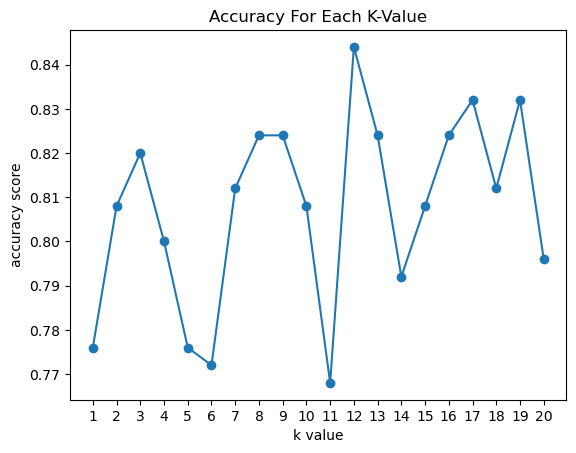

In [6]:
def best_k(n_neighbors):
    """
    Parameters
    ----------
    n_neighbors: the k-value used in knn model 
    
    Returns
    -------
    sum(sample_accuracy)/len(sample_accuracy): float, the accuracy score 
    """
    # creates a copy of the filtered df 
    knn_df = filtered_df.copy()
    # Split into testing and training, set up a classifier
    # drops nan values 
    knn_df = knn_df.dropna(axis = 0)
    knn_df = knn_df.reset_index()

    # uses only the first 100 rows of the dataframe to pick a k-value because it is very large 
    # and takes too long to pass the whole dataset through .predict
    X = knn_df[demographics + behavioral].head(100).values
    y = knn_df[health_stats].head(100).values
    
    
    # sets up test, train, split model 
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    knn = KNeighborsClassifier(n_neighbors)
    # fits the model 
    knn.fit(X_train, y_train)

    # predicts values for the test 
    k_test_predict = knn.predict(X_test)
    expected = y_test

    # metrics cannot calcuate accuracy when there are multiple classifcations, 
    # so instead iterates through each "sample" and caluclates average accuracy score
    # for that k-value 
    sample_accuracy = []
    for i in range(len(X_test)):
        accuracy = metrics.accuracy_score(expected[i], k_test_predict[i])
        sample_accuracy.append(accuracy)
        
    return sum(sample_accuracy)/len(sample_accuracy)


k_list = []
# iterates through k-value 1-20
for i in range(1,21):
    accuracy_score = best_k(i)
    k_list.append(accuracy_score)
    
# plots to see which k-value has highest accuracy 
plt.plot(range(1,21), k_list, marker = "o")
plt.xticks(range(1,21))
plt.xlabel("k value")
plt.ylabel("accuracy score")
plt.title("Accuracy For Each K-Value")
plt.show()
    


In [7]:
def train_knn(filtered_df, user_health, demographics, behavioral, n_neighbors):
    """
    Parameters
    ----------
    filtered_df: cleaned dataframe of health statistics
    user_health: List of floats that contains the users demographic and behavioral information 
    demographics : a list of strings that are the column names of demographic attributes 
    behavioral: a list of strings that are the column names of behavioral attributes 
    
    Returns
    -------
    predicted : list of predicted outomes for chronic diseases based on user health information 
    knn_df_scaled: scaled dataframe with most values between 0-1
    knn_df: original data frame 
    scaled_health: users health values scaled between 0-1
    """
    knn_df = filtered_df.copy()
    # Split into testing and training, set up a classifier
    # drops nan values 
    knn_df = knn_df.dropna(axis = 0)
    knn_df = knn_df.reset_index()
    
    # initializes scaler object to scale values between 0 and 1
    # citation: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
    # citation: https://scikit-learn.org/stable/modules/preprocessing.html
    scaler = StandardScaler()
    knn_df_scaled = scaler.fit_transform(knn_df[demographics + behavioral])
    scaled_health = scaler.fit_transform(user_health)

    # sets the whole dataframe to the x values
    # sets the arthiritus column to y values 
    X = knn_df[demographics + behavioral].values
    y = knn_df[health_stats].values

    # sets up test, train, split model 
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    knn = KNeighborsClassifier(n_neighbors)
    # fits the model 
    knn.fit(X_train, y_train)

    
    predicted = knn.predict(user_health)

    return predicted, knn_df_scaled, knn_df, scaled_health
    
n_neighbors = 19
predicted, knn_df_scaled, knn_df, scaled_health = train_knn(filtered_df, user_health, demographics, behavioral, n_neighbors)

for stat, disease in zip(predicted[0], health_stats):
    if int(stat) == 1 or int(stat) == 3:
        print("The knn model predicts your health outcome to be at risk for having", disease)



The knn model predicts your health outcome to be at risk for having DIABETE4


### Logistic Regression

A logistic regression is used as another tool for classification by producing the probability of an individual
developing a certain chronic condition based on their behavioral and demographic attributes. 

In [8]:
def logistic_regression(knn_df_scaled, scaled_health, condition):
    """
    Parameters
    ----------
    knn_df_scaled: scaled dataframe with most values between 0-1
    knn_df: original data frame with demographic and behavioral attributes 
    scaled_health: users health values scaled between 0-1
    condition: string, condition user wants to predict 
    
    Returns
    -------
    none
    """
    # citation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict
    lr = LogisticRegression(max_iter=400)
    X = knn_df_scaled
    y = knn_df[condition]
    
    lr.fit(X,y)
    
    score = lr.score(X,y)
    print("The R-squared value between your health attributes and", condition, "is", score)
    
    # citation for .predict_proba and parameters
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    user_prediction = lr.predict_proba(scaled_health)
    print("Based on the model, the predicted probability of developing based on your health attributes is"
          , condition, "is", user_prediction[0][1])
    
   

print("Here are a list of chronic conditions:\n")
print("CVDINFR4: Heart Attack, CVDCRHD4: Angina/Coranary heart disease, CVDSTRK3: Stroke, ASTHMA3: Asthma,\n" 
    "CHCCOPD2: COPD, DIABETE4: Diabetes, CHCOCNCR: Cancer")
    
condition = input("\nPlease enter the CODE (Acronym) of the chronic condition you want to predict")

logistic_regression(knn_df_scaled, scaled_health, condition)

Here are a list of chronic conditions:

CVDINFR4: Heart Attack, CVDCRHD4: Angina/Coranary heart disease, CVDSTRK3: Stroke, ASTHMA3: Asthma,
CHCCOPD2: COPD, DIABETE4: Diabetes, CHCOCNCR: Cancer



Please enter the CODE (Acronym) of the chronic condition you want to predict CVDCRHD4


The R-squared value between your health attributes and CVDCRHD4 is 0.9391353615368526
Based on the model, the predicted probability of developing based on your health attributes is CVDCRHD4 is 0.02677184061113797


## **Visualizing the Data**

### K-Means Visualization 
This project uses kmeans to group individuals based on their behavioral and demographic attributes, and visualizes
the data on a scatterplot
* Note, these methods take longer to run

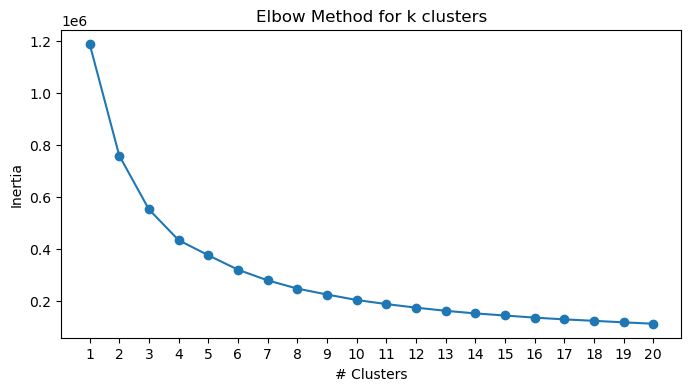

In [9]:
def pick_cluster(knn_df_scaled, knn_df):
    """
    Parameters
    ----------
    knn_df_scaled: scaled dataframe with most values between 0-1
    knn_df: original data frame with demographic and behavioral attributes 
    
    Returns
    -------
    df: dataframe that contains x,y coordinates for each row of the original knn_dataframe
    plot_df: concatenated dataframe that contains new rows with the x,y coordinates and cluster number
    """
    # citation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    # citation: https://www.askpython.com/python/examples/plot-k-means-clusters-python
    # citation: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    
    # initialize pca object
    # components = 2 to flatten to 2 attributes 
    pca = PCA(n_components = 2)
    flat_array = pca.fit_transform(knn_df_scaled)
    # turns the flattened array to a dataframe 
    df = pd.DataFrame(flat_array)
    # sets new headers for the x and y columns 
    df.columns = ["x", "y"]

    # concatenates the filtered dataframe with the dataframe containing
    # x and y coordinates for each row 
    plot_df = pd.concat([knn_df, df], axis = 1)

    
    # elbow method to determine number of clusters
    #initialize empty list 
    inertias = []
    # Tests k-values 1-20 
    k = range(1,21)
    for k_value in k:
        # fits flattened array and uses KMeans to get the clusters
        kmeans = KMeans(n_clusters = k_value, random_state = 42, n_init = 10).fit(flat_array)
        # uses .inertia method to get the inertia of each cluster and appends it to a list
        inertias.append(kmeans.inertia_)
    plt.figure(figsize = (8,4))
    # plots the data on a line graph 
    plt.plot(k, inertias, marker = "o")
    plt.title("Elbow Method for k clusters")
    plt.xlabel("# Clusters")
    plt.ylabel("Inertia")
    plt.xticks(k)
    plt.show

    return df, plot_df

df, plot_df = pick_cluster(knn_df_scaled, knn_df)

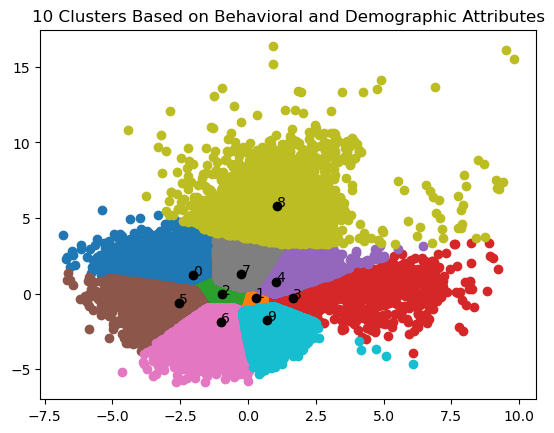

In [10]:
def plot_cluster(df, plot_df):
    """
    Parameters
    ----------
    df: dataframe that contains x,y coordinates for each row of the original knn_dataframe
    plot_df: concatenated dataframe that contains new rows with the x,y coordinates and cluster number
    
    Returns
    -------
    none
    """
    # creates kmeans object 
    kmeans = KMeans(n_clusters = 10, random_state = 19, n_init = 50)
    
    # uses .fit_predicted to assign a cluster to each x,y value in the dataframe 
    label = kmeans.fit_predict(df)
    
    # creates a new column called cluster# to hold the labels for each row 
    plot_df["cluster#"] = label

    # gets a unique list of the 20 clusters 
    unique_clusters = set(plot_df["cluster#"].values)
    
    for i in unique_clusters:
        # creates individual dataframes for each cluster
        individual_df = plot_df[plot_df["cluster#"] == i]
        # plots the x and y values for each cluster 
        plt.scatter(individual_df["x"], individual_df["y"])

    # uses .cluster_centers_ to find the centroids 
    centroids = kmeans.cluster_centers_
    # plots centroids 
    for point in centroids:
        plt.scatter(point[0], point[1], color = "black" )
        
    # labels each centroid with a number 0-19
    for number, centroid in zip(unique_clusters, centroids):
        plt.annotate(number, centroid)

    plt.title("10 Clusters Based on Behavioral and Demographic Attributes")
    plt.show()
   
plot_cluster(df, plot_df)

### Histograms

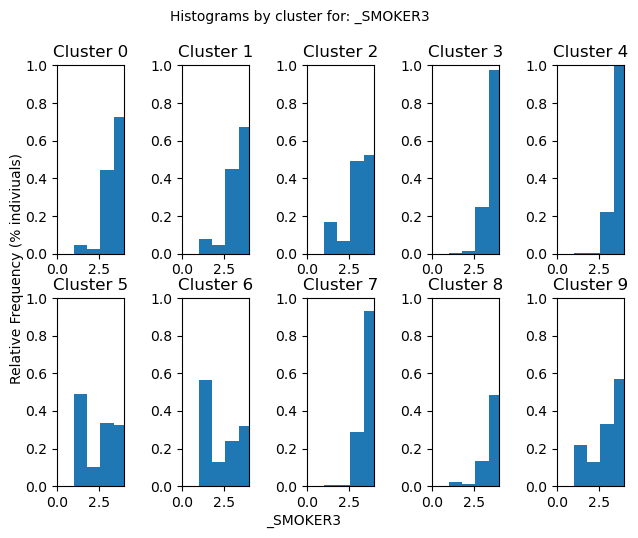

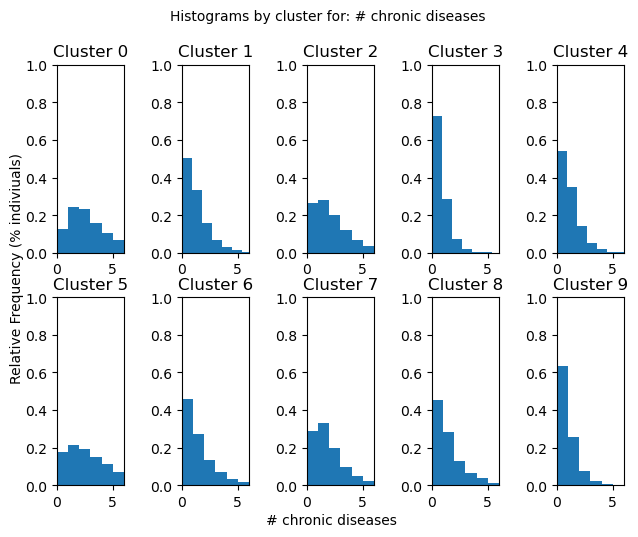

In [11]:
def plot_histogram(knn_df, column, x_axis):
    """
    Parameters
    ----------
    knn_df: original data frame with demographic and behavioral attributes 
    column: string which represents the column name to be displayed 
    x_axis: integer which is the x axis limit 
    
    Returns
    -------
    cluster_dfs: list
    List of individual dataframes for each cluster 
    """
    unique_cluster = set(plot_df["cluster#"])
    cluster_dfs = []
    for cluster in unique_cluster:
        cluster_dfs.append(plot_df[plot_df["cluster#"] == cluster])

    fig, ax = plt.subplots(2,5)
    fig.tight_layout()
    y = 0
    
    for i, cluster in enumerate(cluster_dfs):
        ax[int(i/5),y].set_xlim([0, x_axis])
        ax[int(i/5),y].set_ylim([0, 1])
        ax[int(i/5),y].hist(cluster[column], density=True)
        ax[int(i/5),y].set_title("Cluster " + str(i))
        if y == 4:
            y = 0
        else:
            y += 1

    fig.text(0.4, 0.0001, column)
    fig.text(0, 0.3, "Relative Frequency (% indiviuals)", rotation='vertical')
    fig.text(0.25, 1.05, "Histograms by cluster for: " + column)
    plt.show()
    

    return cluster_dfs
# these histograms will display individuals behavioral attribute of smoking by cluster
column = "_SMOKER3"
x_axis = 4
cluster_dfs = plot_histogram(knn_df, column, x_axis)

# these histograms will display the relative frequency of chronic disesases by cluster 
column = "# chronic diseases"
x_axis = 6
cluster_dfs = plot_histogram(knn_df, column, x_axis)



### K-means and Histogram Analysis
The above figures yield significant results that give insight on the relationship between an behavioral attributes 
and their health outcomes. Smoking was recorded on a scale of 0-4, with 4 being never having smoked, and chronic diseases 
was measured on a scale of the amount of diseases 1-5. Since the lables for the k-means clusters are "randomly" assigned with each iteration, it becomes difficult to write a specific analyisis on the histograms.  However, the general trend seems to be in clusters that
have a lower frequency of indivduals smoking (left-skewed histograms), there seems to be a lower frequency of individuals with 
chronic diseases (right-skewed histograms). This could indicate a correlation between excessive smoking and the prevelance of chronic diseases. There are also clear differences between clusters in each set of histograms, as some have even distributions indicating a higher frequency of individuals with chronic diseases, and some clusters are right-skewed indicating a healthier population

Another observation is that groups which have similar habits, such as smoking, or clusters that had similar distributions of chronic diseases were clustered close together on the k-means graph. The observation that clusters that had similar distributions of chronic diseases were closer together on the kmeans graph indicates that there could be a correlation between behavior and chronic diseases, because clusters were formed based on behavioral and demographic attributes. 

## **Conclusion**
The aim of this project is to cluster and analyze individuals based on their demographic attributes and behavioral attributes to examine their correlation between health outcomes. This is achieved by using K-Nearest Neighbors and Logistic Regression to classify the user's health outcomes, and visualizing the data through Kmeans and histograms. One limitation of this project was that the prediction of a user's health outcome cannot be properly determined due to the lack of biological testing. It would be innacurate to use classification algorithms such as KNN to predict health outcomes, as further testing on a scientific grounds is needed. To account for this, the project instead interprets positive results as a mere correlation rather than a "yes" or "no" answer. Some key observations was that clusters who smoked also had a higher frequency of individuals with chronic diseases. Also, clusters that had higher frequencies of chronic diseases were close together on the KMeans graph, indicating a correlation between demographics, behavior, and chronic health outcomes.  


### Potential Future Implementation
This project can also be useful in informing health officials about which communities are underserved in terms of access to healthcare. 
Historically, low income people of color are disproportionately affected by inadequacies in the American healthcare system leading to 
worse care and health outcomes. This project can be useful in examining these relationships further to draw meaningful conclusions and 
potentially implement new policies to promote equity within the American healthcare system. 
